In [1]:
library(tidyverse)
library(magrittr)
library(cowplot)

gene2snp <- read_tsv("../../data/genesis/gene2snp.hg19", col_types = "cc") %>%
    set_colnames(c("snp", "gene"))

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# χ2 

In [2]:
load("../../data/genesis/epistasis.RData")
epistasis <-  mutate(epistasis,
                     p = pchisq(score, 4),
                     padj = p.adjust(p))

sum(epistasis$padj < 0.05)

[1] 6528

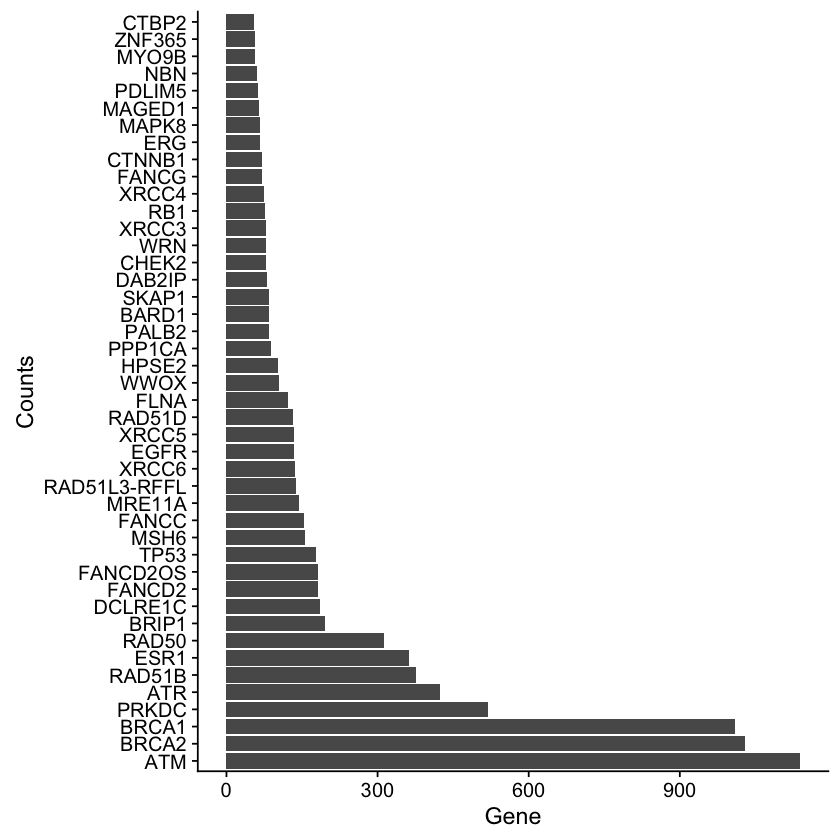

In [3]:
genes <- epistasis %>%
    filter(padj < 0.05) %>% 
    merge(gene2snp, by.y = "snp", by.x = "snp1") %>%
    merge(gene2snp, by.y = "snp", by.x = "snp2", suffixes = c("1","2")) %>%
    select(gene1, gene2)

table(c(genes$gene1, genes$gene2)) %>% 
    sort(decreasing = T) %>% 
    as.data.frame %>% 
    set_colnames(c("gene", "counts")) %>%
    filter(counts > 50) %>%
    ggplot(aes(x = gene, y = counts)) +
        geom_bar(stat="identity") +
        coord_flip() +
        labs(x = "Counts", y = "Gene")

# MBMDR

In [4]:
mbmdr <- read_table("genesis.mbmdr_output.txt", col_types = "ccdd", skip = 2) %>%
    set_colnames(c("snp1", "snp2", "chi2", "p"))

In [5]:
mbmdr %>%
    filter(p < 0.05) %>% 
    merge(gene2snp, by.y = "snp", by.x = "snp1", all.x = T) %>%
    merge(gene2snp, by.y = "snp", by.x = "snp2", all.x = T, suffixes = c("1","2")) %>%
    select(gene1, gene2) %>%
    unique

gene1,gene2
DPP10,NA
